In [2]:
!export MPLCONFIGDIR=/mnt/beegfs/lcesarini/tmp/mat


In [1]:
import os
import sys
sys.path.append("/mnt/beegfs/lcesarini/2022_resilience")
import pickle
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from resilience.utils import get_unlist,get_palettes,plot_bin_hist,read_file_events

os.chdir("/mnt/beegfs/lcesarini/2022_resilience")
sftlf=xr.open_dataset("/mnt/beegfs/lcesarini/DATA_FPS/ECMWF-ERAINT/CNRM/sftlf_ALP-3_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CNRM-AROME41t1_fx_remap.nc")

PATH_COMMON_DATA="/mnt/beegfs/lcesarini/DATA_FPS/ECMWF-ERAINT"
SEAS="JJA"

model=xr.open_mfdataset([f"{PATH_COMMON_DATA}/KNMI/CPM/pr/KNMI_ECMWF-ERAINT_{year}01010030-{year}12312330.nc" for year in np.arange(2000,2001)])
model_slice=model.isel(time=1).load()

# xr.where(sftlf.sftlf > 50,1,0)

idx_on_land=np.argwhere(xr.where(sftlf.sftlf > 50,1,0).values.reshape(-1)==1)
sftlf.sftlf.values.reshape(-1).shape[0]


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g6a2dsb_ because the default path (/home/luigi.cesarini/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


42976

In [3]:
"""
READ THE FILES
"""

model=xr.open_mfdataset([f"{PATH_COMMON_DATA}/KNMI/CPM/pr/KNMI_ECMWF-ERAINT_{year}01010030-{year}12312330.nc" for year in np.arange(2000,2001)])


model_slice=model.isel(time=1).load()

longitude=[]
latitude=[]

import numpy as np
for i in range(158):
    for j in range(272):
        lon,lat=model_slice.isel(lat=i,lon=j).lon.item(),model_slice.isel(lat=i,lon=j).lat.item()

        longitude.append(lon)
        latitude.append(lat)

In [4]:
bins_mw_avg_inte=np.load("/mnt/beegfs/lcesarini/2022_resilience/bins_mw_avg_inte.npy")
bins_mw_max_inte=np.load("/mnt/beegfs/lcesarini/2022_resilience/bins_mw_max_inte.npy")
bins_mw_duration=np.load("/mnt/beegfs/lcesarini/2022_resilience/bins_mw_duration.npy")

In [5]:
l_mw_sph,a_mw_sph,m_mw_sph=read_file_events(EV="mw",MDL='SPHERA',THR=90,INDICES=idx_on_land,SEAS="JJA")


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/lcesarini/EVENTS/mw/SPHERA_len_events_90_JJA.pkl'

In [4]:
H_sph_mw, yedges, xedges = np.histogram2d(
                                        get_unlist(a_mw_sph),
                                        get_unlist(l_mw_sph),
                                        bins=[
                                            bins_mw_avg_inte,
                                            bins_mw_duration,
                                            ]);


In [7]:
list_cpm_mw={}
list_xr_cpm_mw=[]
for i,MDL in enumerate(["KNMI","CMCC","CNRM","KIT","ETH","ICTP","HCLIMcom"]):
    l_mw_cpm,a_mw_cpm,m_mw_cpm=read_file_events(EV="mw",MDL=MDL,THR=90,INDICES=np.arange(len(latitude)),SEAS="JJA")

    dict={MDL:{'length':l_mw_cpm,'avg':a_mw_cpm,'max':m_mw_cpm}} 
    list_cpm_mw.update(dict)

    ds_mw_cpm = xr.Dataset(
        data_vars={
            'n_event':(["lat", "lon"],np.array([len(x) for x in l_mw_cpm]).reshape(158,272)),
            'avg_int':(["lat", "lon"],np.array([np.median(x) for x in a_mw_cpm]).reshape(158,272)),
            'max_int':(["lat", "lon"],np.array([np.median(x) for x in m_mw_cpm]).reshape(158,272)),
        },
        coords={
            'lon':np.unique(longitude),
            'lat':np.unique(latitude)
        },
        attrs=model_slice.attrs,
    )

    list_xr_cpm_mw.append(ds_mw_cpm)


In [8]:
list_H2_w=[]

for NM in ["KNMI","CMCC","CNRM","KIT","ETH","ICTP","HCLIMcom"]:
    H, yedges, xedges = np.histogram2d(get_unlist(list_cpm_mw[NM]['avg']),
                                       get_unlist(list_cpm_mw[NM]['length']),
                                        bins=[
                                            bins_mw_avg_inte,
                                            bins_mw_duration,
                                            ]);

    list_H2_w.append(H)


H2_mw=np.stack(list_H2_w,axis=0).mean(axis=0)

Text(0.5, 0.98, 'Two-dimensional histogram for Wind')

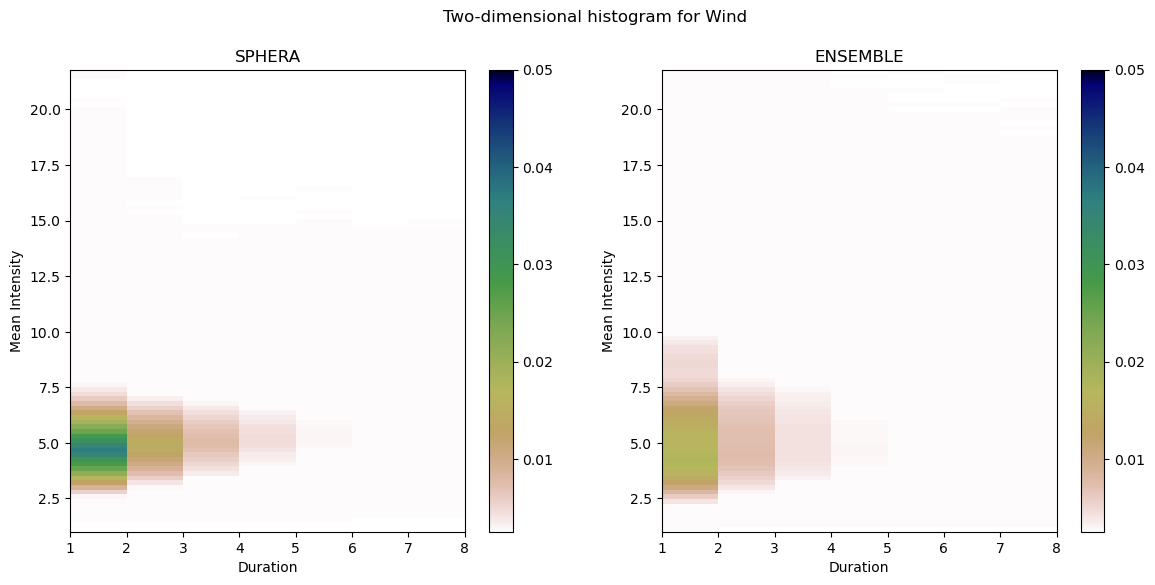

In [10]:
import matplotlib as mpl

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6), sharey=False)

pcm=ax1.pcolormesh(bins_mw_duration, (bins_mw_avg_inte), np.where(H_sph_mw==0,np.nan,H_sph_mw)/np.nansum(np.where(H_sph_mw==0,np.nan,H_sph_mw)), 
                    cmap=mpl.colormaps['gist_earth_r'],
                    norm=mpl.colors.Normalize(vmin=0.0025,vmax=0.05)
                    )
ax1.set_ylim((np.min(bins_mw_avg_inte)), (np.max(bins_mw_avg_inte)))
# ax1.set_ylim((np.min(max_inte)), 20)
ax1.set_xlim(np.min(bins_mw_duration),  np.min([np.max(bins_mw_duration),8]))        # ax1.set_xlim(np.min(duration), 20)
ax1.set_ylabel('Mean Intensity')
ax1.set_xlabel('Duration')
ax1.set_title('SPHERA')
# ax1.set_xticks(np.arange(0,10,2))
# ax1.set_xticklabels(np.arange(0,10,2))
# ax1.set_yticks(([5,10,20,50,100,170]))
# ax1.set_yticklabels([5,10,20,50,100,170])
# ax1.grid()
cbar = plt.colorbar(pcm)
# Set colorbar label
cbar.set_label('', rotation=270, labelpad=20)

pcm2=ax2.pcolormesh(bins_mw_duration, (bins_mw_avg_inte), np.where(H2_mw==0,np.nan,H2_mw)/np.nansum(np.where(H2_mw==0,np.nan,H2_mw)),
                    cmap=mpl.colormaps['gist_earth_r'],
                    norm=mpl.colors.Normalize(vmin=0.0025,vmax=0.05)
                    )
ax2.set_ylim((np.min(bins_mw_avg_inte)), (np.max(bins_mw_avg_inte)))
ax2.set_xlim(np.min(bins_mw_duration),  np.min([np.max(bins_mw_duration),8]))
ax2.set_ylabel('Mean Intensity')
ax2.set_xlabel('Duration')
ax2.set_title('ENSEMBLE')

cbar = plt.colorbar(pcm2)
# Set colorbar label
cbar.set_label('', rotation=270, labelpad=20)
plt.suptitle(f"Two-dimensional histogram for Wind")

In [17]:
len(bins_mw_duration),len(bins_mw_avg_inte)

(127, 100)

In [55]:
bins_mw_avg_inte[:40]

array([1.  , 1.21, 1.42, 1.63, 1.84, 2.05, 2.26, 2.47, 2.68, 2.89, 3.1 ,
       3.31, 3.52, 3.73, 3.94, 4.15, 4.36, 4.57, 4.78, 4.99, 5.2 , 5.41,
       5.62, 5.83, 6.04, 6.25, 6.46, 6.67, 6.88, 7.09, 7.3 , 7.51, 7.72,
       7.93, 8.14, 8.35, 8.56, 8.77, 8.98, 9.19])

In [59]:
bin_inte=30
H2_mod_mw_reduced=(np.where(H2_mw==0,np.nan,H2_mw)/np.nansum(np.where(H2_mw==0,np.nan,H2_mw)))[0:bin_inte,0:8]
H2_sph_mw_reduced=(np.where(H_sph_mw==0,np.nan,H_sph_mw)/np.nansum(np.where(H_sph_mw==0,np.nan,H_sph_mw)))[0:bin_inte,0:8]

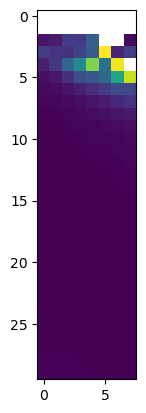

In [60]:
BIAS=(H2_mod_mw_reduced-H2_sph_mw_reduced) / H2_sph_mw_reduced
plt.imshow(BIAS)

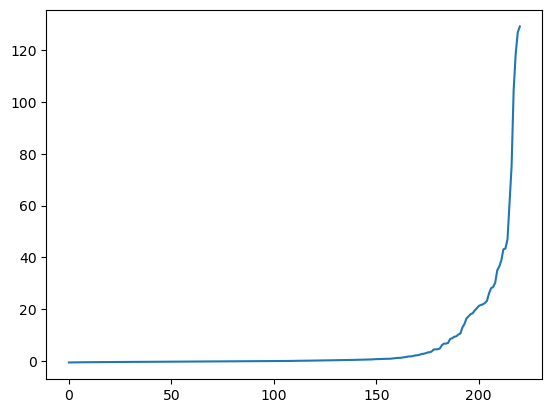

In [66]:
plt.plot(np.sort(BIAS.reshape(-1)))

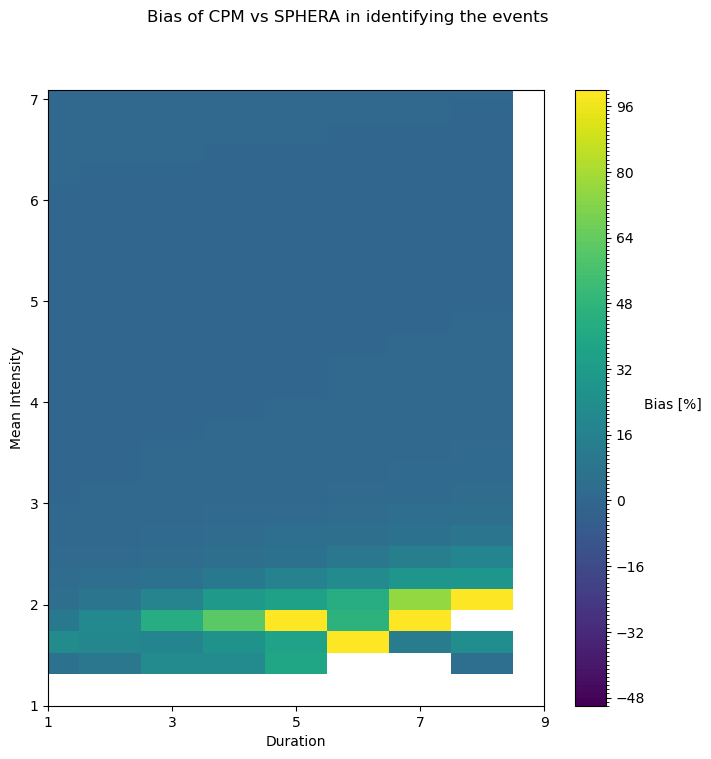

In [63]:
boundaries = np.arange(-50, 101, 1)

# Create a colormap
cmap = plt.cm.get_cmap('viridis', len(boundaries) - 1)
from matplotlib.colors import BoundaryNorm

# Create a BoundaryNorm instance
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
fig, ax2 = plt.subplots(ncols=1,figsize=(8,8), sharey=False)

pcm2=ax2.pcolormesh(bins_mw_duration[:8], bins_mw_avg_inte[:bin_inte], BIAS, 
                    cmap=cmap,#mpl.colormaps['turbo'],
                    norm=norm#mpl.colors.Normalize(vmin=0.0,vmax=0.04)
                    )
ax2.set_ylim(np.min(bins_mw_avg_inte[:bin_inte]), np.max(bins_mw_avg_inte[:bin_inte]))
ax2.set_xlim(np.min(bins_mw_duration[:8]), np.min([np.max(bins_mw_duration[:8]),8]))
ax2.set_ylabel('Mean Intensity')
ax2.set_xlabel('Duration')
ax2.set_title('')
# ax2.set_yticks(np.arange(0,100,2.5))
# ax2.set_yticklabels(position=np.arange(0,100,10),labels=np.arange(0,100,10))
ax2.set_xticks(np.arange(1,11,2))
ax2.set_xticklabels(labels=np.arange(1,11,2))
# ax2.set_yticks([5,10,20,50,100,170]))
# ax2.set_yticklabels([5,10,20,50,100,170])
cbar = plt.colorbar(pcm2)
# Set colorbar label
cbar.set_label('Bias [%]', rotation=0, labelpad=20)
plt.suptitle(f"Bias of CPM vs SPHERA in identifying the events")
plt.show()


In [68]:
l_cb_sph,a_cb_sph,m_cb_sph=read_file_events(EV="combined",MDL='SPHERA',THR=90,INDICES=np.arange(len(latitude)),SEAS="JJA")
l_cb_cpm,a_cb_cpm,m_cb_cpm=read_file_events(EV="combined",MDL='KNMI',THR=90,INDICES=np.arange(len(latitude)),SEAS="JJA")

In [75]:
{
        'lon':np.unique(longitude),
        'lat':np.unique(latitude)
        
}

{'lon': array([ 6.5       ,  6.5274992 ,  6.5549984 ,  6.5824976 ,  6.6099968 ,
         6.63749599,  6.66499519,  6.69249439,  6.71999359,  6.74749279,
         6.77499199,  6.80249119,  6.82999039,  6.85748959,  6.88498878,
         6.91248798,  6.93998718,  6.96748638,  6.99498558,  7.02248478,
         7.04998398,  7.07748318,  7.10498238,  7.13248158,  7.15998077,
         7.18747997,  7.21497917,  7.24247837,  7.26997757,  7.29747677,
         7.32497597,  7.35247517,  7.37997437,  7.40747356,  7.43497276,
         7.46247196,  7.48997116,  7.51747036,  7.54496956,  7.57246876,
         7.59996796,  7.62746716,  7.65496635,  7.68246555,  7.70996475,
         7.73746395,  7.76496315,  7.79246235,  7.81996155,  7.84746075,
         7.87495995,  7.90245914,  7.92995834,  7.95745754,  7.98495674,
         8.01245594,  8.03995514,  8.06745434,  8.09495354,  8.12245274,
         8.14995193,  8.17745113,  8.20495033,  8.23244953,  8.25994873,
         8.28744793,  8.31494713,  8.3424463

In [77]:
ds_cb_sph = xr.Dataset(
    data_vars={
        'n_event':(["lat", "lon"],np.array([len(x) for x in l_cb_sph]).reshape(158,272)),
        'avg_int':(["lat", "lon"],np.array([np.median(x) for x in a_cb_sph]).reshape(158,272)),
        'max_int':(["lat", "lon"],np.array([np.median(x) for x in m_cb_sph]).reshape(158,272)),
    }
,
    coords={
        'lon':np.unique(longitude),
        'lat':np.unique(latitude)
    }
    ,
    attrs=model_slice.attrs,
)

In [78]:
ds_cb_cpm = xr.Dataset(
    data_vars={
        'n_event':(["lat", "lon"],np.array([len(x) for x in l_cb_cpm]).reshape(158,272)),
        'avg_int':(["lat", "lon"],np.array([np.median(x) for x in a_cb_cpm]).reshape(158,272)),
        'max_int':(["lat", "lon"],np.array([np.median(x) for x in m_cb_cpm]).reshape(158,272)),
    },
    coords={
        'lon':np.unique(longitude),
        'lat':np.unique(latitude)
    },   
    attrs=model_slice.attrs,
)

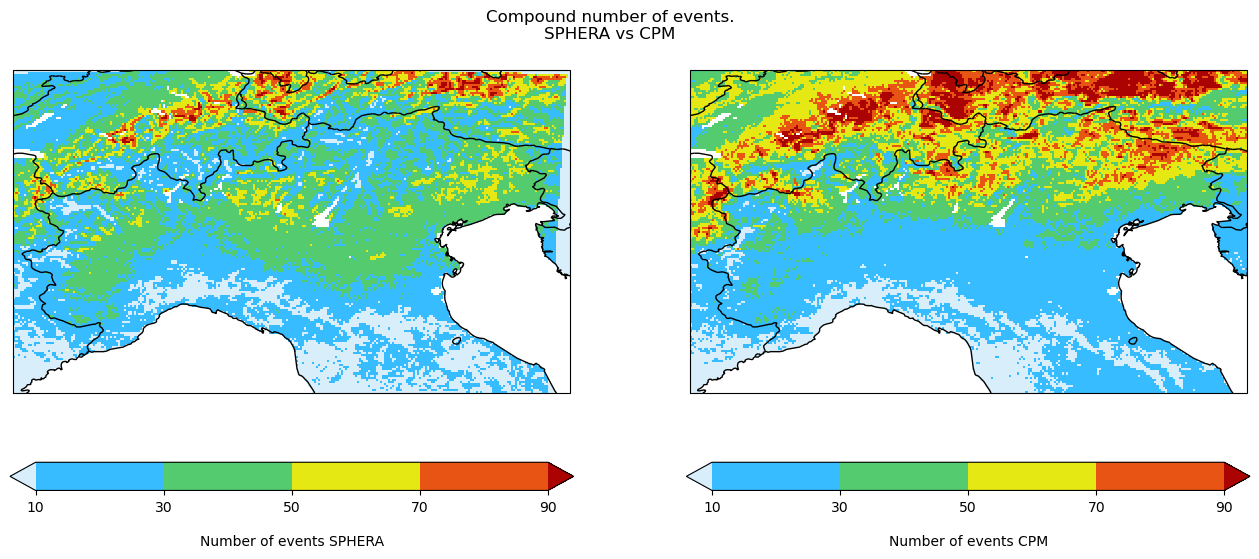

In [80]:
cmap_q=get_palettes()[2]
fig,ax = plt.subplots(1,2, figsize=(16,6),subplot_kw={"projection":ccrs.PlateCarree()})

img1=(ds_cb_sph.n_event * xr.where(sftlf.sftlf > 50,1,np.nan)).plot(cmap=cmap_q,
                                                                    levels=np.arange(10,91,20),#np.arange(1,8,1),
                                                                    ax=ax[0],add_colorbar=False)
img2=(ds_cb_cpm.n_event * xr.where(sftlf.sftlf > 50,1,np.nan)).plot(cmap=cmap_q,
                                                                    levels=np.arange(10,91,20),#np.arange(1,8,1),
                                                                    ax=ax[1],add_colorbar=False)

[ax[_].coastlines() for _ in range(2)]
[ax[_].add_feature(cfeature.BORDERS) for _ in range(2)]
# Add colorbar labels
cbar1 = plt.colorbar(img1,ax=ax[0],orientation='horizontal')
cbar1.set_label('Number of events SPHERA', rotation=0, labelpad=15)

cbar2 = plt.colorbar(img2,ax=ax[1],orientation='horizontal')
cbar2.set_label('Number of events CPM', rotation=0, labelpad=15)
plt.suptitle("Compound number of events.\nSPHERA vs CPM");

In [91]:
_x=ds_cb_cpm.n_event * xr.where(sftlf.sftlf > 50,1,np.nan)
_y=ds_cb_sph.n_event * xr.where(sftlf.sftlf > 50,1,np.nan)
BIAS_COMBINED=(_x-_y)/_y * 100
# (_x-_y) / _y
BIAS_COMBINED

<xarray.DataArray (lat: 158, lon: 272)>
array([[   0.        ,    0.        ,  -25.        , ...,           nan,
                  nan,           nan],
       [ -33.33333333,    0.        ,    0.        , ...,           nan,
                  nan,           nan],
       [ -50.        , -100.        ,   66.66666667, ...,           nan,
                  nan,           nan],
       ...,
       [  88.88888889,   65.2173913 ,   56.52173913, ...,   19.11764706,
          16.17647059,           inf],
       [          inf,           inf,           inf, ...,           inf,
                  inf,           inf],
       [          inf,           inf,           inf, ...,           inf,
                  inf,           inf]])
Coordinates:
  * lon      (lon) float64 6.5 6.527 6.555 6.582 6.61 ... 13.87 13.9 13.92 13.95
  * lat      (lat) float64 43.25 43.28 43.3 43.33 ... 47.48 47.51 47.54 47.57

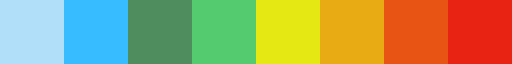

In [95]:
levels=[np.arange(-50,51,10),np.arange(-50,51,10),np.arange(-50,51,10)],


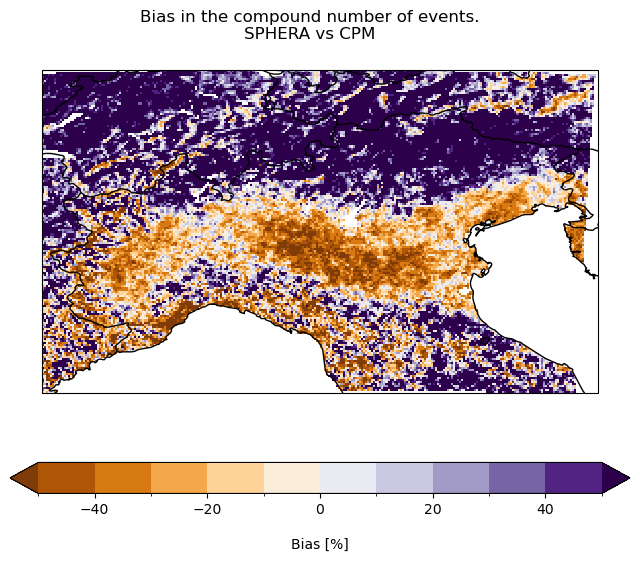

In [96]:
cmap_q=get_palettes()[2]
fig,ax = plt.subplots(1,1, figsize=(8,6),subplot_kw={"projection":ccrs.PlateCarree()})

img1=(BIAS_COMBINED).plot(cmap="PuOr",
                                                                    levels=np.arange(-50,51,10),#np.arange(1,8,1),
                                                                    ax=ax,add_colorbar=False)

ax.coastlines() 
ax.add_feature(cfeature.BORDERS)
# Add colorbar labels
cbar1 = plt.colorbar(img1,ax=ax,orientation='horizontal')
cbar1.set_label('Bias [%]', rotation=0, labelpad=15)

plt.suptitle("Bias in the compound number of events.\nSPHERA vs CPM");